In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
# new import statements
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

### Retailrocket recommender system dataset

Source: https://www.kaggle.com/retailrocket/ecommerce-dataset

Load the dataset files.

In [2]:
events = pd.read_csv(os.path.join('data', 'events.csv'))
item_properties = pd.read_csv(os.path.join('data', 'item_properties_part1.csv'))
category_tree = pd.read_csv(os.path.join('data', 'category_tree.csv'))

In [3]:
events

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN


In [4]:
item_properties

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
...,...,...,...,...
10999994,1439694000000,86599,categoryid,618
10999995,1435460400000,153032,1066,n1020.000 424566
10999996,1440298800000,421788,888,35975 856003 37346
10999997,1437879600000,159792,400,n552.000 639502 n720.000 424566


In [5]:
category_tree

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0
...,...,...
1664,49,1125.0
1665,1112,630.0
1666,1336,745.0
1667,689,207.0


In [6]:
events['event_datetime'] = pd.to_datetime(events['timestamp'], unit='ms')
events['event_date'] = events['event_datetime'].dt.date
events

,timestamp,visitorid,event,itemid,transactionid,event_datetime,event_date
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,2015-06-02
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,2015-06-02
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,2015-06-02
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,2015-06-02
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,2015-06-02
...,...,...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN,2015-08-01 03:13:05.939,2015-08-01
2756097,1438399813142,762376,view,115946,NaN,2015-08-01 03:30:13.142,2015-08-01
2756098,1438397820527,1251746,view,78144,NaN,2015-08-01 02:57:00.527,2015-08-01
2756099,1438398530703,1184451,view,283392,NaN,2015-08-01 03:08:50.703,2015-08-01


### 3. ARIMA (Autoregressive Integrated Moving Average) model

### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

Autocorrelation and partial autocorrelation are statistical measures that help analyze the relationship between a time series and its lagged values. They help identify patterns, trends, and dependencies in the data, which are crucial for model selection and evaluation.

### Autocorrelation

- Autocorrelation measures the linear relationship between a time series and its lagged values. In simpler terms, it assesses how much the current value of a series depends on its past values. 
- Used for identifying the order of a moving average (MA) process.
- Represents the overall correlation structure of the time series.
- Autocorrelation measures the linear relationship between an observation and its previous observations at different lags.
- Use case:
    - To identify repeated patterns (seasonality).
    - To assess whether a time series is random or has some dependency.
    - To decide if a time series has autoregressive (AR) components.

### Partial Autocorrelation
- Partial autocorrelation removes the influence of intermediate lags, providing a clearer picture of the direct relationship between a variable and its past values. Unlike autocorrelation, partial autocorrelation focuses on the direct correlation at each lag.
- Used for identifying the order of an autoregressive (AR) process.
- Highlights the direct relationships between observations at specific lags.
- Partial Autocorrelation measures the direct linear relationship between an observation and its previous observations at a specific lag, excluding the contributions from intermediate lags.
- Use case:
    - To determine the order of an autoregressive (AR) process.
    - To identify the number of lags that have a significant and direct impact on the current value.

In [7]:
category_items = item_properties[item_properties['property'] == 'categoryid'][['itemid', 'value']]
# 'value' column contains the category IDs, so let's rename value to categoryid
category_items.columns = ['itemid', 'categoryid']  
category_items['categoryid'] = category_items['categoryid'].astype(int)
category_items

,itemid,categoryid
0,460429,1338
140,281245,1277
151,35575,1059
189,8313,1147
197,55102,47
...,...,...
10999880,441523,1167
10999917,250848,769
10999932,116380,1509
10999960,84186,209


In [8]:
events_with_categories = pd.merge(events, category_items, on="itemid", how="left")
events_with_categories

,timestamp,visitorid,event,itemid,transactionid,event_datetime,event_date,categoryid
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,2015-06-02,1173.0
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,2015-06-02,NaN
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,2015-06-02,NaN
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,2015-06-02,NaN
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,2015-06-02,NaN
...,...,...,...,...,...,...,...,...
4439576,1438398785939,591435,view,261427,NaN,2015-08-01 03:13:05.939,2015-08-01,NaN
4439577,1438399813142,762376,view,115946,NaN,2015-08-01 03:30:13.142,2015-08-01,1616.0
4439578,1438397820527,1251746,view,78144,NaN,2015-08-01 02:57:00.527,2015-08-01,969.0
4439579,1438398530703,1184451,view,283392,NaN,2015-08-01 03:08:50.703,2015-08-01,NaN


### ACF and PACF for the whole view count timeseries

In [9]:
grouped_data = (
    events_with_categories[events_with_categories['event'] == 'view']
    .groupby(['event_date', 'categoryid'])
    .size()
    .reset_index(name='view_count') 
)
grouped_data

,event_date,categoryid,view_count
0,2015-05-03,0.0,3
1,2015-05-03,1.0,17
2,2015-05-03,3.0,5
3,2015-05-03,5.0,31
4,2015-05-03,14.0,63
...,...,...,...
95935,2015-09-18,1650.0,3
95936,2015-09-18,1659.0,6
95937,2015-09-18,1663.0,3
95938,2015-09-18,1680.0,1


In [10]:
per_day_data = grouped_data.groupby('event_date')['view_count'].sum().reset_index()
per_day_data

,event_date,view_count
0,2015-05-03,16405
1,2015-05-04,22200
2,2015-05-05,25861
3,2015-05-06,26558
4,2015-05-07,27054
...,...,...
134,2015-09-14,20405
135,2015-09-15,20149
136,2015-09-16,11647
137,2015-09-17,11968


In [11]:
autocorr_values = per_day_data['view_count'].autocorr()
print("Autocorrelation:", autocorr_values)

Autocorrelation: 0.6897774661516713


### ARIMA `q` determination

- `p`: The order of the Moving Average (MA) Term
- What is `q`? The number of lagged forecast errors included in the model.
- How to determine it from ACF plot?
    - Look for a significant spike and where it cuts off. The lag at the cut-off point indicates p.

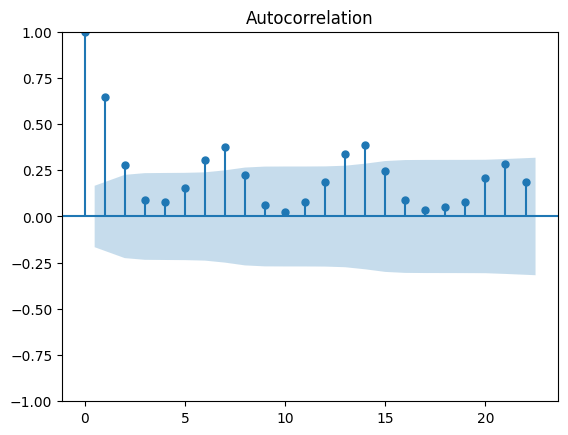

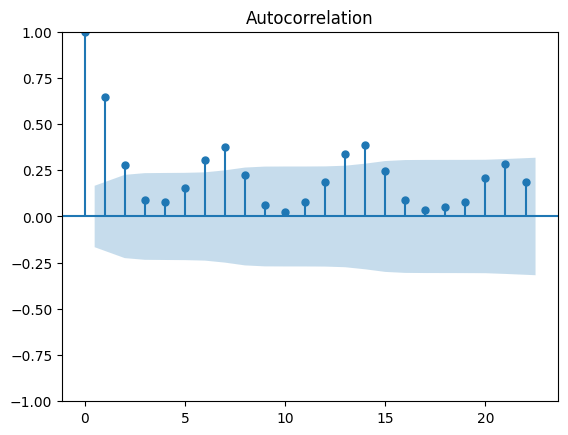

In [12]:
plot_acf(per_day_data['view_count'])

### ARIMA `p` determination

- `p`: The order of the Autoregressive (AR) Term
- What is `p`? The number of lagged observations used to predict the series.
- How to determine it from PACF plot?
    - Look for a significant spike (above the confidence interval) and where it cuts off. The lag at the cut-off point indicates p.

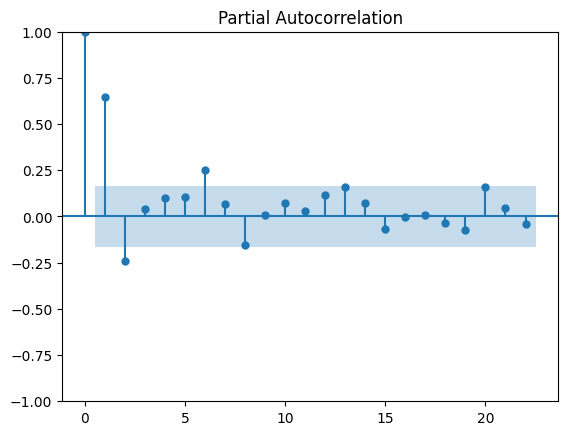

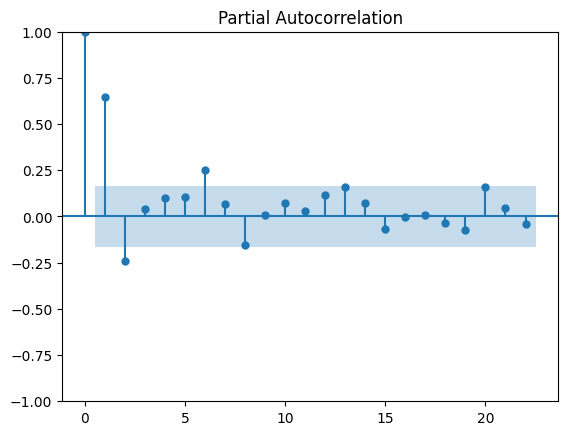

In [13]:
plot_pacf(per_day_data['view_count'])

### Differencing

Differencing is a technique used in time series analysis to transform a non-stationary series into a stationary series by subtracting the current value of the series from its previous value. The goal of differencing is to eliminate trends, seasonality, and other non-stationary components to make the series more suitable for modeling with methods like ARIMA. A stationary series has constant mean, variance, and autocorrelation over time.

In [14]:
grouped_data

,event_date,categoryid,view_count
0,2015-05-03,0.0,3
1,2015-05-03,1.0,17
2,2015-05-03,3.0,5
3,2015-05-03,5.0,31
4,2015-05-03,14.0,63
...,...,...,...
95935,2015-09-18,1650.0,3
95936,2015-09-18,1659.0,6
95937,2015-09-18,1663.0,3
95938,2015-09-18,1680.0,1


In [15]:
grouped_data['diff_view_count'] = grouped_data['view_count'].diff()
grouped_data

,event_date,categoryid,view_count,diff_view_count
0,2015-05-03,0.0,3,NaN
1,2015-05-03,1.0,17,14.0
2,2015-05-03,3.0,5,-12.0
3,2015-05-03,5.0,31,26.0
4,2015-05-03,14.0,63,32.0
...,...,...,...,...
95935,2015-09-18,1650.0,3,1.0
95936,2015-09-18,1659.0,6,3.0
95937,2015-09-18,1663.0,3,-3.0
95938,2015-09-18,1680.0,1,-2.0


In [16]:
grouped_data = grouped_data.dropna()
grouped_data

,event_date,categoryid,view_count,diff_view_count
1,2015-05-03,1.0,17,14.0
2,2015-05-03,3.0,5,-12.0
3,2015-05-03,5.0,31,26.0
4,2015-05-03,14.0,63,32.0
5,2015-05-03,23.0,1,-62.0
...,...,...,...,...
95935,2015-09-18,1650.0,3,1.0
95936,2015-09-18,1659.0,6,3.0
95937,2015-09-18,1663.0,3,-3.0
95938,2015-09-18,1680.0,1,-2.0


### Visual difference between original series and differentiated series

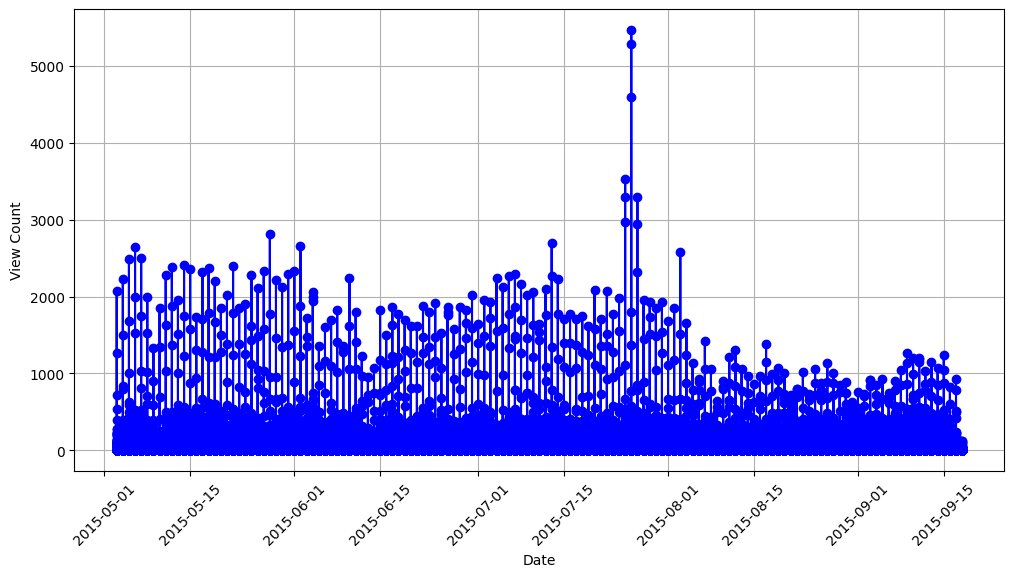

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(grouped_data['event_date'], grouped_data['view_count'], marker='o', linestyle='-', color='blue')
plt.xlabel('Date')
plt.ylabel('View Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

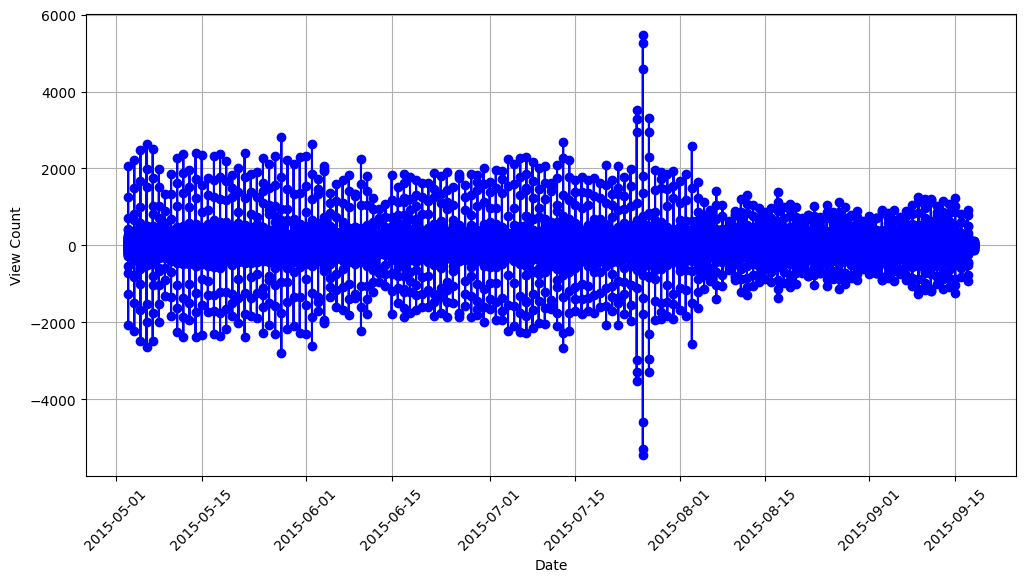

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(grouped_data['event_date'], grouped_data['diff_view_count'], marker='o', linestyle='-', color='blue')
plt.xlabel('Date')
plt.ylabel('View Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

#### Autocorrelation of the stationary series

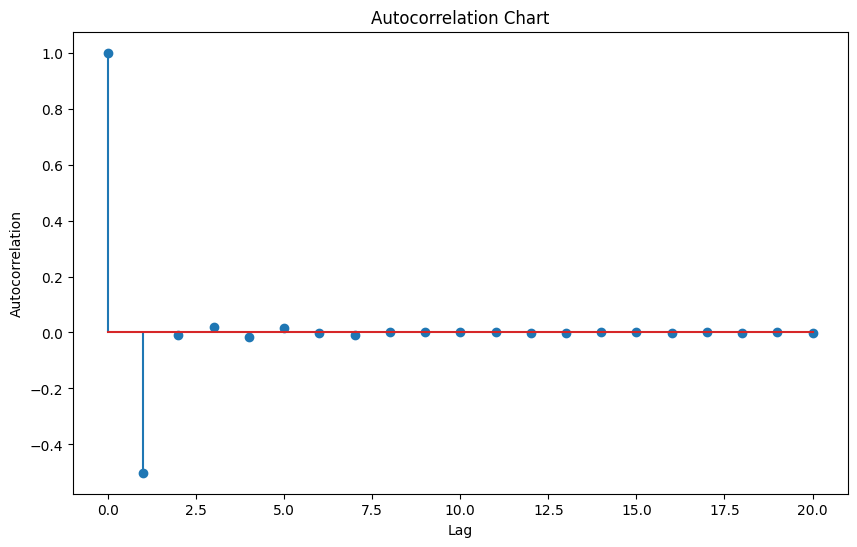

In [19]:
autocorrelation = sm.tsa.acf(grouped_data['diff_view_count'], nlags=20)

plt.figure(figsize=(10, 6))
plt.stem(range(len(autocorrelation)), autocorrelation)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Chart')
plt.show()

### Augmented Dickey-Fuller (ADF) test

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series is stationary or non-stationary. Stationarity is an important assumption in many time series analysis models.

The ADF test evaluates the null hypothesis (H₀) that the time series has a unit root, indicating non-stationarity. The alternative hypothesis (H₁) is that the time series is stationary.

When performing the ADF test, we obtain the ADF statistic and the p-value. The ADF statistic is a negative number and the more negative it is, the stronger the evidence against the null hypothesis. The p-value represents the probability of observing the ADF statistic or a more extreme value if the null hypothesis were true. A low p-value (below a chosen significance level, typically 0.05) indicates strong evidence against the null hypothesis and suggests that the time series is stationary.

In [20]:
result = adfuller(grouped_data['diff_view_count'][:10000])

adf_statistic = result[0]
p_value = result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

ADF Statistic: -28.023070902781225
p-value: 0.0


### ARIMA

In [21]:
d = 1 
p = 2
q = 2

It is recommended to convert your data type to `float64` before performing ARIMA forecasting.

In [22]:
model = sm.tsa.ARIMA(grouped_data['view_count'].values.astype('float64'), order=(p, d, q))
result = model.fit()

In [23]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                95939
Model:                 ARIMA(2, 1, 2)   Log Likelihood             -586800.741
Date:                Wed, 27 Nov 2024   AIC                        1173611.483
Time:                        18:33:56   BIC                        1173658.840
Sample:                             0   HQIC                       1173625.881
                              - 95939                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6396      0.201     -3.181      0.001      -1.034      -0.246
ar.L2         -0.0281      0.007     -3.871      0.000      -0.042      -0.014
ma.L1         -0.3793      0.201     -1.885      0.0

#### Prediction for the next 30 days

In [24]:
predictions = result.forecast(steps=30)
print(predictions)

[21.81652226 21.33862598 21.08734666 21.26150014 21.15717121 21.21900695
 21.18238807 21.20407215 21.19123186 21.19883527 21.19433289 21.19699898
 21.19542025 21.1963551  21.19580153 21.19612933 21.19593522 21.19605016
 21.1959821  21.1960224  21.19599854 21.19601267 21.1960043  21.19600926
 21.19600632 21.19600806 21.19600703 21.19600764 21.19600728 21.19600749]
